# General Preamble Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
import urllib.request
import tarfile
import io
import seaborn as sns
import warnings
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Additional code for GE Dataset

In [4]:
# For GE, additional import code:
def load_tcga_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz'
    try:
        with urllib.request.urlopen(url) as response:
            with tarfile.open(fileobj=io.BytesIO(response.read()), mode="r:gz") as tar:
                data_path = 'TCGA-PANCAN-HiSeq-801x20531/data.csv'
                labels_path = 'TCGA-PANCAN-HiSeq-801x20531/labels.csv'
                data_file = tar.extractfile(data_path)
                X = pd.read_csv(data_file, index_col=0)
                labels_file = tar.extractfile(labels_path)
                labels_df = pd.read_csv(labels_file, index_col=0)
                y = labels_df['Class']
                return X, y
    except Exception as e:
        print(f"Failed to download or process data. Error: {e}")
        return None, None
X, y = load_tcga_data()

# Question 1
- Standardize the training and test sets using StandardScaler into (X_train_scaled). How many samples are there in your training dataset?
- Train a KNeighborsClassifier (n_neighbors=5) on the standardized, full-dimensional training data.Report the model's accuracy on the standardized test set. Also use the %%time magic command to measure and report the total time it takes to fit the model and make predictions.
- Now, do the above step and train 2 additional KNNs on only the first 300 samples, and the first 450 samples in the datasets. Plot the accuracy and time taken with 300, 450, and 600 on the x-axis and the corresponding values of time and accuracy on the y-axis.
- Does this plot allow you to guesstimate the time and accuracy when there are 50,000 patients in the dataset? What challenges does a distance-based algorithm like KNN still face on a scaled, but very high-dimensional, dataset?

############ Assignment 7 Question 1 BEGIN ############
Number of samples in training dataset: 600
Accuracy on standardized test set: 0.9900
Accuracy 300 samples: 0.9950, Time: 0.29s
Accuracy 450 samples: 0.9950, Time: 0.46s
Accuracy 600 samples: 0.9900, Time: 0.45s


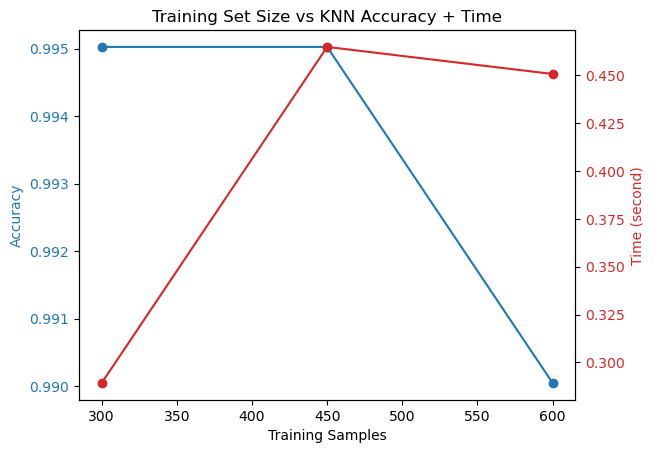

I would say that it is not possible to extrapolate the plot to 50000 pateients because the plot does not show a clear trend that can be reliably extended to such a large sample size.
This is because KNN faces challenges in high dimensions due to the curse of dimensionality, making distance less meaningful and computation expensive even with scaling. Especially with 50,000 patients, time and memory requirements would grow rapidly exponentially.
############# Assignment 7 Question 1 END #############


In [6]:
print("############ Assignment 7 Question 1 BEGIN ############")
# part a
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Number of samples in training dataset: {X_train.shape[0]}")

# part b
knn_full = KNeighborsClassifier(n_neighbors=5)
knn_full.fit(X_train_scaled, y_train)
y_pred_full = knn_full.predict(X_test_scaled)
print(f"Accuracy on standardized test set: {accuracy_score(y_test, y_pred_full):.4f}")

# part c
sample_sizes = [300, 450, 600]
accuracies = []
times = []

for n in sample_sizes:
    X_train_n = X_train_scaled[:n]
    y_train_n = y_train.iloc[:n]
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_n, y_train_n)
    y_pred = knn.predict(X_test_scaled)
    elapsed = time.time() - start
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    times.append(elapsed)
    print(f"Accuracy {n} samples: {acc:.4f}, Time: {elapsed:.2f}s")

# Plot accuracy and time
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Training Samples')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(sample_sizes, accuracies, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time (second)', color=color)
ax2.plot(sample_sizes, times, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Set Size vs KNN Accuracy + Time')
plt.show()

# part d
print("I would say that it is not possible to extrapolate the plot to 50000 pateients because the plot does not show a clear trend that can be reliably extended to such a large sample size.")
print("This is because KNN faces challenges in high dimensions due to the curse of dimensionality, making distance less meaningful and computation expensive even with scaling. Especially with 50,000 patients, time and memory requirements would grow rapidly exponentially.")
print("############# Assignment 7 Question 1 END #############")


In [7]:
%time
for n in sample_sizes:
    X_train_n = X_train_scaled[:n]
    y_train_n = y_train.iloc[:n]
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_n, y_train_n)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Accuracy {n} samples: {acc:.4f}")

CPU times: total: 0 ns
Wall time: 0 ns
Accuracy 300 samples: 0.9950
Accuracy 450 samples: 0.9950
Accuracy 600 samples: 0.9900


# Question 2
- Fit an instance of PCA on the standardized training data (X_train_scaled). Do not specify the number of components yet.
- Generate a "scree plot" by creating a bar chart of the explained_variance_ratio_ for the first 50 principal components. 
- Generate a cumulative explained variance plot for the first 50 components. On the same plot, add a horizontal line at y=0.90 to represent the 90% threshold.
- Based on your cumulative plot, approximately how many principal components are required to capture 90% of the total variance?


############ Assignment 7 Question 2 BEGIN ############


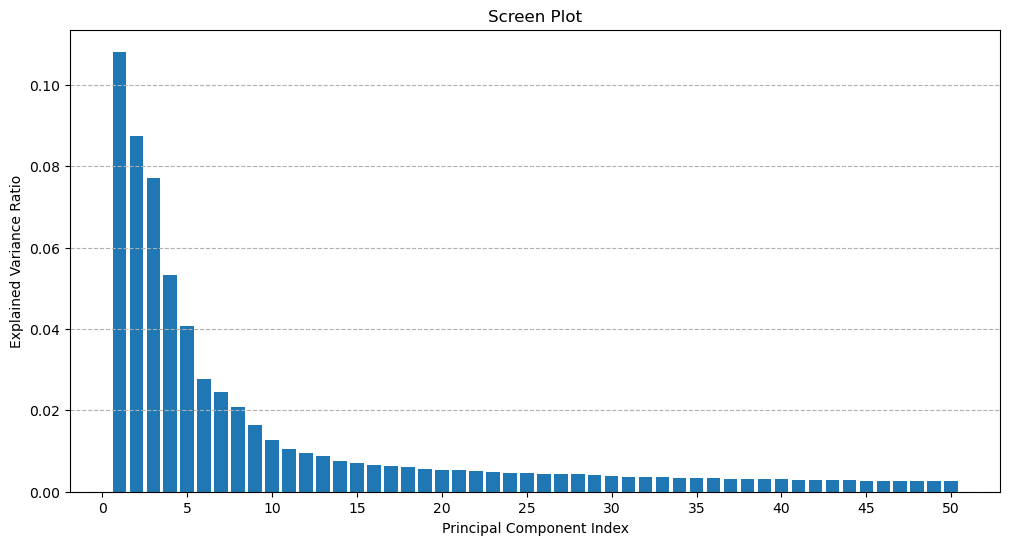

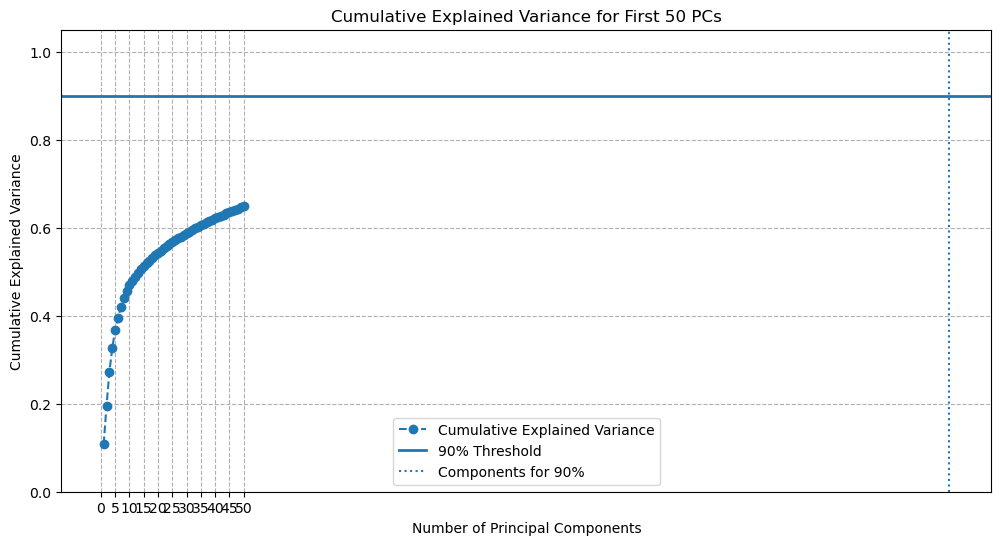

Approximately 297 principal components are required to capture 90% of the total variance.
############# Assignment 7 Question 2 END #############


In [9]:
print("############ Assignment 7 Question 2 BEGIN ############")

pca = PCA()
pca.fit(X_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

n_components_to_plot = 50

plt.figure(figsize=(12, 6))
plt.bar(range(1, n_components_to_plot + 1), explained_variance_ratio[:n_components_to_plot], label="Individual Explained Variance Ratio")
plt.title(f"Screen Plot")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.grid(axis="y", linestyle="--")
plt.xticks(range(0, n_components_to_plot + 1, 5))
plt.show()

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components_to_plot + 1), cumulative_variance[:n_components_to_plot], marker="o", linestyle="--",label="Cumulative Explained Variance")

threshold = 0.90
plt.axhline(y=threshold, linestyle="-", linewidth=2,label=f"{threshold*100:.0f}% Threshold")

n_components_90 = np.argmax(cumulative_variance >= threshold) + 1

plt.axvline(x=n_components_90, linestyle=":",label=f"Components for {threshold*100:.0f}%",)
    
plt.title(f"Cumulative Explained Variance for First {n_components_to_plot} PCs")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend(loc="best")
plt.grid(True, linestyle="--")
plt.xticks(range(0, n_components_to_plot + 1, 5))
plt.ylim(0, 1.05)
plt.show()

print(f"Approximately {n_components_90} principal components are required to capture 90% of the total variance.")

print("############# Assignment 7 Question 2 END #############")

# Question 3
- Use the PCA model from Question 2 create the following 2D scatter plot. Color each point in the scatter plot according to its true cancer type (y_test). 
    - X-axis is PC1, y-axis PC2
    - X-axis is PC1, y-axis PC3 
    - X-axis PC2, y-axis PC3
    - X-axis PC1, y-axis PC4
- Based on your plots, how well does each combination of principal components separate the different cancer types? Why would it be impossible to create such an informative plot using any two of the original 20,000+ genes?


In [11]:
print("############ Assignment 7 Question 3 BEGIN ############")

print("############# Assignment 7 Question 3 END #############")

############ Assignment 7 Question 3 BEGIN ############
############# Assignment 7 Question 3 END #############


# Question 4
- Create a new PCA instance, setting n_components to the number you identified in Question 2d to capture 90% of the variance. Fit this new PCA on the standardized training data and use it to transform both the training and test sets.
- Train the same KNeighborsClassifier from Question 1 on this new, lower-dimensional PCA-transformed training data again for 300, 450, and 600 samples.
- Report the accuracy and use %%time to report the total time for fitting and prediction and compare the accuracy and total time of this model to your baseline model in Question and draw the same plot relative to different sample sizes.
- What does this "apples-to-apples" comparison tell you about the specific advantages of PCA for an algorithm like KNN, especially if extrapolated to a situation where we might have 50,000 patients in the data?


In [13]:
print("############ Assignment 7 Question 4 BEGIN ############")

print("############# Assignment 7 Question 4 END #############")

############ Assignment 7 Question 4 BEGIN ############
############# Assignment 7 Question 4 END #############


# Question 5
- Extract the loadings for the first principal component (PC1) from the components_ attribute of the PCA model fit in Question 2. 
- Find the top 10 genes with the largest absolute loading values and report their loading values. 
- Create a horizontal bar chart to visualize the loadings of these top 10 genes. 
- In a biological context, what does it mean for these specific genes to have high loading values on the first principal component? 

In [15]:
print("############ Assignment 7 Question 5 BEGIN ############")

print("############# Assignment 7 Question 5 END #############")

############ Assignment 7 Question 5 BEGIN ############
############# Assignment 7 Question 5 END #############


# Question 6
- Use the PCA model from Question 4 (explaining 90% variance) to inverse_ transform your X_train_pca data back to the ~20k dimensions. Calculate the Mean Squared Error (MSE) between the original X_train_scaled and this new reconstructed data. What does this error represent?
- To visualize this, create a line plot showing the expression levels of the first 200 genes for the first patient in the original X_train_scaled data. On the same plot, show the expression levels for the same patient from the reconstructed data.

In [17]:
print("############ Assignment 7 Question 6 BEGIN ############")

print("############# Assignment 7 Question 6 END #############")

############ Assignment 7 Question 6 BEGIN ############
############# Assignment 7 Question 6 END #############


# Question 7
- The Necessity of Scaling for PCA Explain, with reference to how PCA's algorithm is based on maximizing variance, why failing to scale features like gene expression levels would lead to a meaningless result. How does this differ from decision trees?


In [19]:
print("############ Assignment 7 Question 7 BEGIN ############")

print("############# Assignment 7 Question 7 END #############")

############ Assignment 7 Question 7 BEGIN ############
############# Assignment 7 Question 7 END #############


# Question 8
- Interpretability: Like question 5b, now write out the top 10 genes of the first 5 principal components trained in Question 2 and their corresponding loading values. If you’re a data scientist with no biological background, and you are asked to explain the meaning of each of the principal components would you be able to explain it? How might a biologist use their expertise to explain each principal component better?

In [21]:
print("############ Assignment 7 Question 8 BEGIN ############")

print("############# Assignment 7 Question 8 END #############")

############ Assignment 7 Question 8 BEGIN ############
############# Assignment 7 Question 8 END #############


# Question 9
- Bioinformatics: This lab demonstrates a standard bioinformatics workflow: scaling -> PCA -> algorithmic processing. Explain why this approach is so powerful for finding meaningful patterns in massive genomic datasets and its importance for cancer research.

In [23]:
print("############ Assignment 7 Question 9 BEGIN ############")

print("############# Assignment 7 Question 9 END #############")

############ Assignment 7 Question 9 BEGIN ############
############# Assignment 7 Question 9 END #############
